In [ ]:
# Setup: Install Dependencies
!pip install transformers datasets torch scikit-learn tabulate matplotlib seaborn -q

In [1]:
# Import Libraries
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tabulate import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration & Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
# Choose Pretrained Model and Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
# Define Tasks (GLUE + External Datasets)
tasks = {
    "SST-2": ("glue", "sst2"),             # Sentiment
    "QQP": ("glue", "qqp"),                # Paraphrase
    "MNLI": ("glue", "mnli"),              # Natural Language Inference
    "Amazon Reviews": ("amazon_polarity", None),  # Domain Sentiment
}

In [5]:
# Helper Functions
def preprocess_function(examples):
    # Handle single or paired sentence inputs dynamically
    if "sentence1" in examples and "sentence2" in examples:
        return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, padding="max_length", max_length=128)
    elif "sentence" in examples:
        return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)
    elif "text" in examples:
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    elif "content" in examples:
        return tokenizer(examples["content"], truncation=True, padding="max_length", max_length=128)
    else:
        return tokenizer(examples[list(examples.keys())[0]], truncation=True, padding="max_length", max_length=128)


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}



 Loading dataset for EDA: glue


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]


 Dataset shape: (67349, 3)
 Columns: ['sentence', 'label', 'idx']

 Sample Data:
                                            sentence  label  idx
0       hide new secretions from the parental units       0    0
1               contains no wit , only labored gags       0    1
2  that loves its characters and communicates som...      1    2
3  remains utterly satisfied to remain the same t...      0    3
4  on the worst revenge-of-the-nerds clichés the ...      0    4


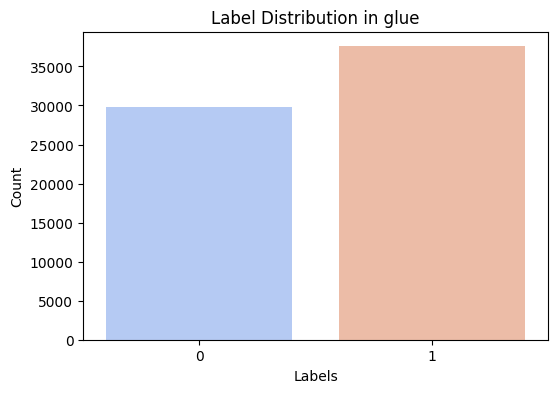

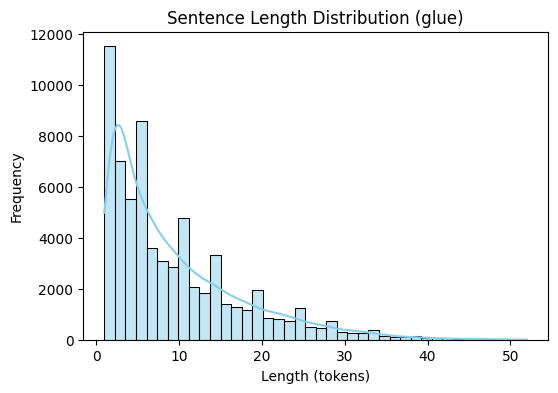

In [ ]:
# Exploratory Data Analysis (EDA)
def eda_overview(dataset_name, subset=None, sample_size=5):
    print(f"\n Loading dataset for EDA: {dataset_name}")
    dataset = load_dataset(dataset_name, subset) if subset else load_dataset(dataset_name)
    df = pd.DataFrame(dataset["train"])
    print(f"\n Dataset shape: {df.shape}")
    print(f" Columns: {df.columns.tolist()}")
    print(f"\n Sample Data:\n{df.head(sample_size)}")

    # Label distribution
    if "label" in df.columns:
        label_col = "label"
    elif "labels" in df.columns:
        label_col = "labels"
    else:
        label_col = None

    if label_col:
        plt.figure(figsize=(6,4))
        sns.countplot(x=label_col, data=df, palette="coolwarm")
        plt.title(f"Label Distribution in {dataset_name}")
        plt.xlabel("Labels")
        plt.ylabel("Count")
        plt.show()

    # Sentence length distribution
    text_col = "sentence" if "sentence" in df.columns else "text" if "text" in df.columns else list(df.columns)[0]
    df["length"] = df[text_col].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(6,4))
    sns.histplot(df["length"], bins=40, kde=True, color="skyblue")
    plt.title(f"Sentence Length Distribution ({dataset_name})")
    plt.xlabel("Length (tokens)")
    plt.ylabel("Frequency")
    plt.show()

# Run EDA for one dataset as example
eda_overview("glue", "sst2")

In [ ]:
# Few-Shot Training Configuration
few_shot_settings = {"k=0": 0, "k=1": 1, "k=4": 4}
results = []

Using transformers version: 4.56.2

 Running task: SST-2

 EDA for SST-2 (subset):


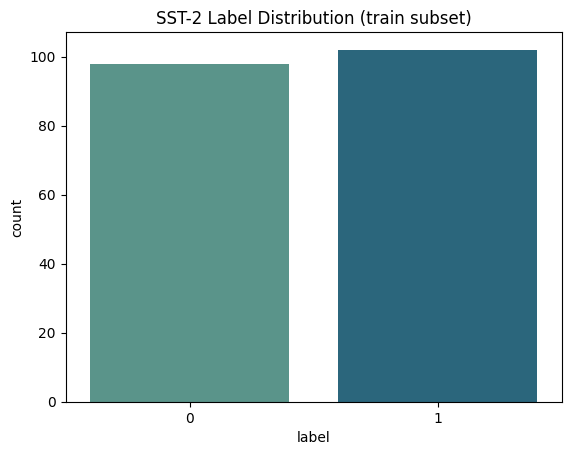

   Setting k=0 (0 epochs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=1 (1 epochs)
Training model for 1 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.643445,0.620000,0.750962,0.620000,0.565436


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=4 (4 epochs)
Training model for 4 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.410403,0.840000,0.842315,0.840000,0.839808
2,No log,0.477634,0.810000,0.828560,0.810000,0.806985
3,No log,0.517161,0.855000,0.855276,0.855000,0.854946
4,No log,0.607020,0.850000,0.850110,0.850000,0.849970


Evaluating model...



 Running task: QQP

 EDA for QQP (subset):


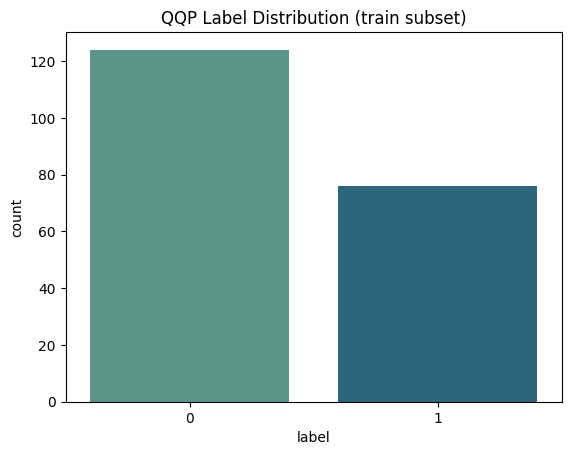

   Setting k=0 (0 epochs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=1 (1 epochs)
Training model for 1 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.640138,0.660000,0.435600,0.660000,0.524819


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=4 (4 epochs)
Training model for 4 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.623883,0.655000,0.598100,0.655000,0.567612
2,No log,0.622551,0.640000,0.609126,0.640000,0.613592
3,No log,0.748496,0.585000,0.634341,0.585000,0.595911
4,No log,0.710696,0.645000,0.651518,0.645000,0.647868


Evaluating model...



 Running task: MNLI

 EDA for MNLI (subset):


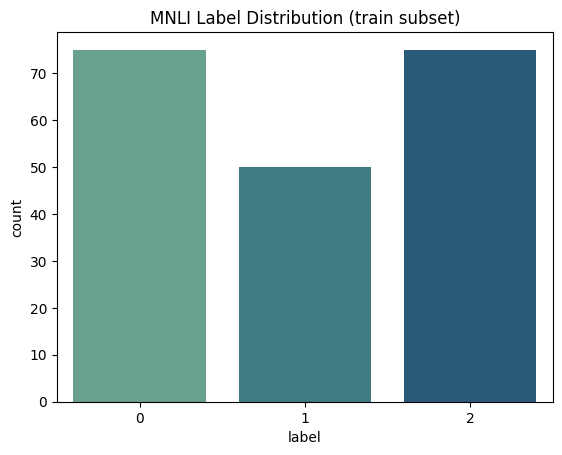

   Setting k=0 (0 epochs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=1 (1 epochs)
Training model for 1 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.092186,0.410000,0.315227,0.410000,0.246886


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=4 (4 epochs)
Training model for 4 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.098088,0.375000,0.396067,0.375000,0.365266
2,No log,1.096351,0.400000,0.381484,0.400000,0.368787
3,No log,1.225870,0.315000,0.334086,0.315000,0.291215
4,No log,1.236296,0.355000,0.355292,0.355000,0.354505


Evaluating model...



 Running task: Amazon Reviews


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]


 EDA for Amazon Reviews (subset):


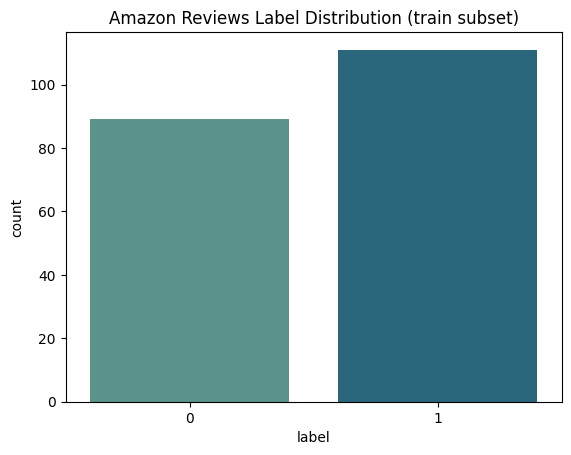

   Setting k=0 (0 epochs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=1 (1 epochs)
Training model for 1 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.443910,0.840000,0.844840,0.840000,0.840321


Evaluating model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Setting k=4 (4 epochs)
Training model for 4 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.397324,0.835000,0.856560,0.835000,0.834525
2,No log,0.344793,0.870000,0.874105,0.870000,0.868803
3,No log,0.568553,0.855000,0.862708,0.855000,0.855236
4,No log,0.617821,0.865000,0.872760,0.865000,0.865220


Evaluating model...


In [ ]:
# Model Training & Evaluation Loop
from transformers import __version__ as transformers_version
print(f"Using transformers version: {transformers_version}")

for task_name, (dataset_name, subset) in tasks.items():
    print(f"\n Running task: {task_name}")
    raw_datasets = load_dataset(dataset_name, subset) if subset else load_dataset(dataset_name)

    label_col = "label" if "label" in raw_datasets["train"].column_names else "labels"
    num_labels = len(set(raw_datasets["train"][label_col]))

    # Tokenize dataset
    tokenized = raw_datasets.map(preprocess_function, batched=True)
    small_train = tokenized["train"].shuffle(seed=42).select(range(500))

    available_splits = list(tokenized.keys())

    # For GLUE datasets like MNLI that have "validation_matched"
    if "validation" in available_splits:
        eval_split = "validation"
    elif "validation_matched" in available_splits:
        eval_split = "validation_matched"
    elif "test" in available_splits:
        eval_split = "test"
    elif "test_matched" in available_splits:
        eval_split = "test_matched"
    else:
        # fallback: just use first non-train split
        eval_split = [s for s in available_splits if s != "train"][0]

    small_eval = tokenized[eval_split].select(range(min(200, len(tokenized[eval_split]))))



    # Visual EDA (optional)
    print(f"\n EDA for {task_name} (subset):")
    df_small = pd.DataFrame(raw_datasets["train"][:200])
    if label_col in df_small.columns:
        sns.countplot(x=label_col, data=df_small, palette="crest")
        plt.title(f"{task_name} Label Distribution (train subset)")
        plt.show()

    for setting, epochs in few_shot_settings.items():
        print(f"   Setting {setting} ({epochs} epochs)")

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(DEVICE)

        # If zero-shot (k=0), just evaluate without training
        if epochs == 0:
            trainer = Trainer(model=model, tokenizer=tokenizer, compute_metrics=compute_metrics)
        else:

            try:
                training_args = TrainingArguments(
                    output_dir=f"./results_{task_name}_{setting}",
                    num_train_epochs=epochs,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    eval_strategy="epoch",      # renamed param for safety
                    save_strategy="no",
                    logging_dir="./logs",
                    disable_tqdm=False,
                    report_to="none"
                )
            except TypeError:
                # fallback for older versions
                training_args = TrainingArguments(
                    output_dir=f"./results_{task_name}_{setting}",
                    num_train_epochs=epochs,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    save_strategy="no",
                    logging_dir="./logs",
                    disable_tqdm=False
                )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=small_train,
                eval_dataset=small_eval,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
            )

            print(f"Training model for {epochs} epoch(s)...")
            trainer.train()

        # Evaluate
        print("Evaluating model...")
        metrics = trainer.evaluate(eval_dataset=small_eval)
        acc, prec, rec, f1 = metrics.get("eval_accuracy", 0), metrics.get("eval_precision", 0), metrics.get("eval_recall", 0), metrics.get("eval_f1", 0)
        majority_baseline = 50.0
        results.append([task_name, setting, f"{acc*100:.2f}%", f"{prec*100:.2f}%", f"{rec*100:.2f}%", f"{f1*100:.2f}%", f"{majority_baseline:.2f}%"])

In [ ]:
# Display Final Results Table
print("\n FEW-SHOT EVALUATION (BERT-base, MT-DNN style)")
print("===========================================================")
print(tabulate(results, headers=["Task", "Setting", "Accuracy", "Precision", "Recall", "F1-Score", "Majority Baseline"], tablefmt="github"))



 FEW-SHOT EVALUATION (BERT-base, MT-DNN style)
| Task           | Setting   | Accuracy   | Precision   | Recall   | F1-Score   | Majority Baseline   |
|----------------|-----------|------------|-------------|----------|------------|---------------------|
| SST-2          | k=0       | 46.50%     | 44.58%      | 46.50%   | 40.42%     | 50.00%              |
| SST-2          | k=0       | 44.00%     | 43.84%      | 44.00%   | 43.76%     | 50.00%              |
| SST-2          | k=1       | 62.00%     | 75.10%      | 62.00%   | 56.54%     | 50.00%              |
| SST-2          | k=4       | 85.00%     | 85.01%      | 85.00%   | 85.00%     | 50.00%              |
| QQP            | k=0       | 35.00%     | 49.05%      | 35.00%   | 23.83%     | 50.00%              |
| QQP            | k=1       | 66.00%     | 43.56%      | 66.00%   | 52.48%     | 50.00%              |
| QQP            | k=4       | 64.50%     | 65.15%      | 64.50%   | 64.79%     | 50.00%              |
| SST-2         

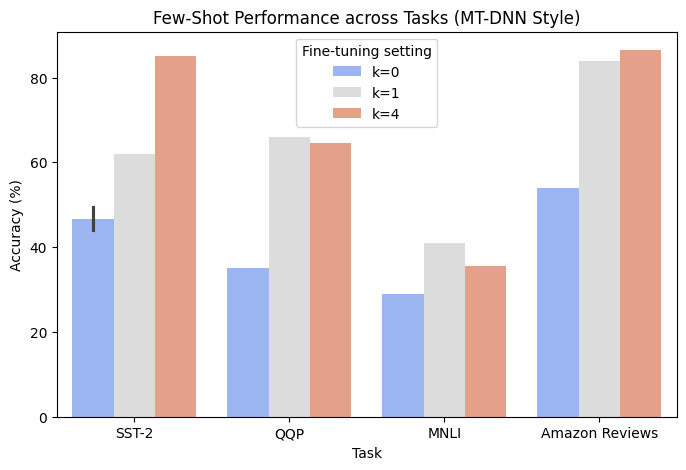

In [ ]:
# Visualizing Results
df_results = pd.DataFrame(results, columns=["Task", "Setting", "Accuracy", "Precision", "Recall", "F1-Score", "Baseline"])
df_results["Accuracy"] = df_results["Accuracy"].str.replace("%", "").astype(float)

plt.figure(figsize=(8,5))
sns.barplot(x="Task", y="Accuracy", hue="Setting", data=df_results, palette="coolwarm")
plt.title("Few-Shot Performance across Tasks (MT-DNN Style)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Fine-tuning setting")
plt.show()

In [ ]:
df_results.to_csv("fewshot_results.csv", index=False)
print("\nResults saved as 'fewshot_results.csv'.")


Results saved as 'fewshot_results.csv'.


In [ ]:
from datasets import load_dataset

In [ ]:
print("\n Adding Custom Real-World Dataset: IMDB Movie Reviews")


 Adding Custom Real-World Dataset: IMDB Movie Reviews


In [3]:
# Load IMDB dataset (binary sentiment classification)
imdb = load_dataset("imdb")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
# Tokenize using the same preprocessing
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
# Select smaller subset for quick few-shot runs
small_train = tokenized_imdb["train"].shuffle(seed=42).select(range(500))
small_eval = tokenized_imdb["test"].select(range(200))

In [11]:
df_imdb = pd.DataFrame(imdb["train"][:200])
df_imdb["length"] = df_imdb["text"].astype(str).apply(lambda x: len(x.split()))
print(f"\nIMDB Dataset: {len(imdb['train'])} training samples, {len(imdb['test'])} test samples")
print(f"Average review length: {df_imdb['length'].mean():.1f} words")


IMDB Dataset: 25000 training samples, 25000 test samples
Average review length: 225.8 words


In [12]:
df_imdb.head()

,text,label,length
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214
2,If only to avoid making this type of film in t...,0,93
3,This film was probably inspired by Godard's Ma...,0,118
4,"Oh, brother...after hearing about this ridicul...",0,311


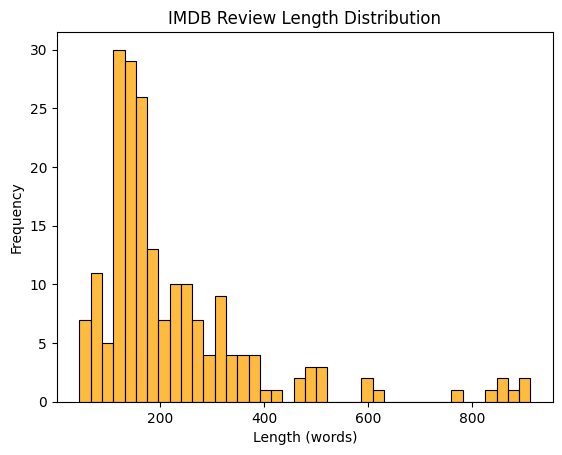

In [ ]:
sns.histplot(df_imdb["length"], bins=40, color="orange")
plt.title("IMDB Review Length Distribution")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Train and evaluate few-shot models
for setting, epochs in few_shot_settings.items():
    print(f"\n Training on IMDB ({setting}, {epochs} epoch(s))")

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(DEVICE)

    if epochs == 0:
        trainer = Trainer(model=model, tokenizer=tokenizer, compute_metrics=compute_metrics)
    else:
        from transformers import TrainingArguments
        training_args = TrainingArguments(
            output_dir=f"./results_IMDB_{setting}",
            num_train_epochs=epochs,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            eval_strategy="epoch",
            save_strategy="no",
            logging_dir="./logs",
            disable_tqdm=False,
            report_to="none"
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=small_train,
            eval_dataset=small_eval,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()

    print(" Evaluating IMDB...")
    metrics = trainer.evaluate(eval_dataset=small_eval)
    acc, prec, rec, f1 = metrics.get("eval_accuracy", 0), metrics.get("eval_precision", 0), metrics.get("eval_recall", 0), metrics.get("eval_f1", 0)
    majority_baseline = 50.0
    results.append(["Custome Dataset (read world)", setting, f"{acc*100:.2f}%", f"{prec*100:.2f}%", f"{rec*100:.2f}%", f"{f1*100:.2f}%", f"{majority_baseline:.2f}%"])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training on IMDB (k=0, 0 epoch(s))
 Evaluating IMDB...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training on IMDB (k=1, 1 epoch(s))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.663232,0.920000,1.000000,0.920000,0.958333


 Evaluating IMDB...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training on IMDB (k=4, 4 epoch(s))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.877716,0.580000,1.000000,0.580000,0.734177
2,No log,0.931282,0.635000,1.000000,0.635000,0.776758
3,No log,0.483510,0.835000,1.000000,0.835000,0.910082
4,No log,0.967419,0.730000,1.000000,0.730000,0.843931


 Evaluating IMDB...


In [ ]:
print("\nFEW-SHOT EVALUATION RESULTS (Including Custom Dataset)")
print(tabulate(results, headers=["Task", "Setting", "Accuracy", "Precision", "Recall", "F1-Score", "Majority Baseline"], tablefmt="github"))



FEW-SHOT EVALUATION RESULTS (Including Custom Dataset)
| Task                         | Setting   | Accuracy   | Precision   | Recall   | F1-Score   | Majority Baseline   |
|------------------------------|-----------|------------|-------------|----------|------------|---------------------|
| SST-2                        | k=0       | 46.50%     | 44.58%      | 46.50%   | 40.42%     | 50.00%              |
| SST-2                        | k=0       | 44.00%     | 43.84%      | 44.00%   | 43.76%     | 50.00%              |
| SST-2                        | k=1       | 62.00%     | 75.10%      | 62.00%   | 56.54%     | 50.00%              |
| SST-2                        | k=4       | 85.00%     | 85.01%      | 85.00%   | 85.00%     | 50.00%              |
| QQP                          | k=0       | 35.00%     | 49.05%      | 35.00%   | 23.83%     | 50.00%              |
| QQP                          | k=1       | 66.00%     | 43.56%      | 66.00%   | 52.48%     | 50.00%              |


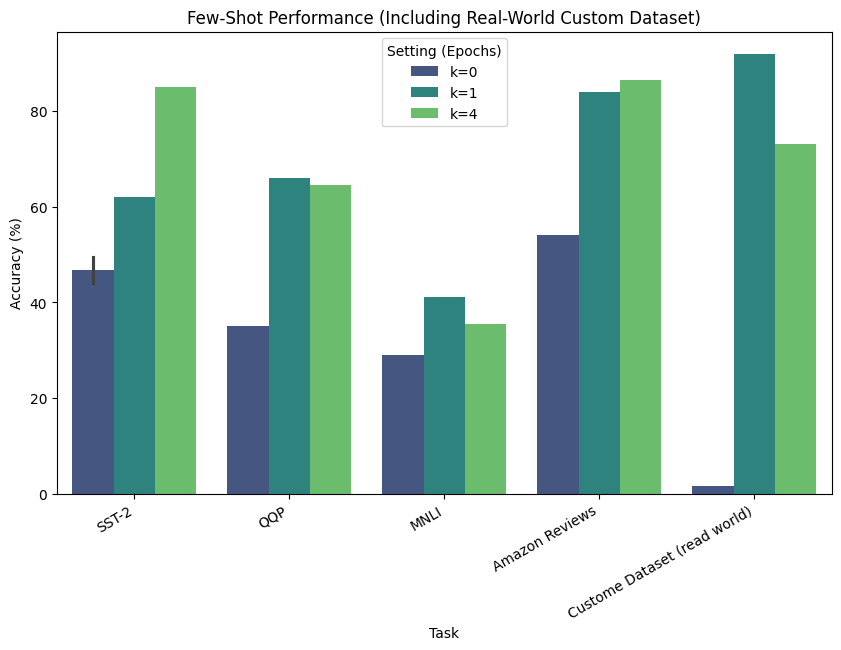

In [ ]:
df_results = pd.DataFrame(results, columns=["Task", "Setting", "Accuracy", "Precision", "Recall", "F1-Score", "Baseline"])
df_results["Accuracy"] = df_results["Accuracy"].str.replace("%", "").astype(float)

plt.figure(figsize=(10,6))
sns.barplot(x="Task", y="Accuracy", hue="Setting", data=df_results, palette="viridis")
plt.title("Few-Shot Performance (Including Real-World Custom Dataset)")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Setting (Epochs)")
plt.show()
